In [4]:
import numpy as np
import pandas as pd
import numpy.matlib
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import logsumexp
import random
from sklearn import mixture
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons

import seaborn as sns

Text(0.5, 1.0, 'Simulated 1D Data denstiy')

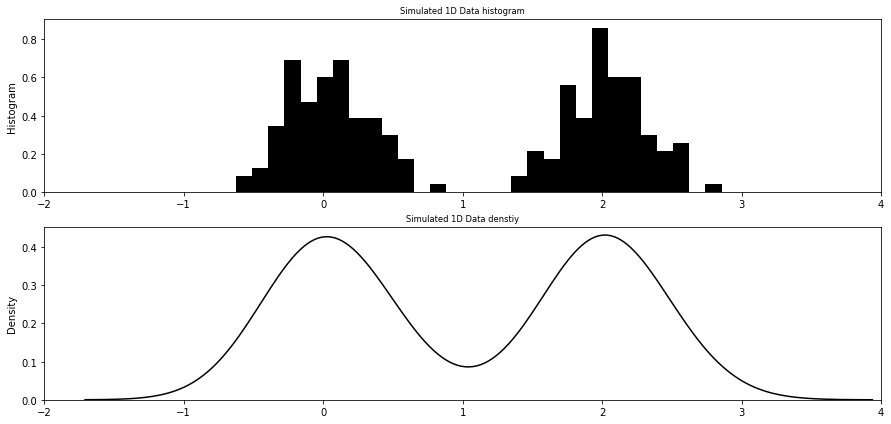

In [5]:
#group one
mu1, sigma1 = 0, 0.3 # mean and standard deviation
s1 = np.random.normal(mu1, sigma1, 100)
y1 = np.repeat(0, 100)

#group two
mu2, sigma2 = 2, 0.3 # mean and standard deviation
s2 = np.random.normal(mu2, sigma2, 100)
y2 = np.repeat(1, 100)

#mix model
mu = [mu1, mu2]
sigma = [sigma1, sigma2]
data = np.concatenate([s1,s2])
y = np.concatenate([y1,y2])

plt.figure(figsize = (15,7))
ax1 = plt.subplot(211)
plt.hist(data , color = 'k' ,bins = 30 , density  = True)
plt.ylabel('Histogram')
plt.xlim(-2,4)
plt.title('Simulated 1D Data histogram' , fontsize = 'small')

ax2 = plt.subplot(212 ,sharex = ax1)
sns.kdeplot(data , color = 'k')
plt.title('Simulated 1D Data denstiy' , fontsize = 'small')


In [6]:
#Functions
#input some points x and the parameters mu and sigma associated to the two group s, and compute the probabilitis that each
#points is at the location it is  knowing it is in the two group . This is the N(x_n | mu,sigma).
def pr_single_comp(mu, sigma, x):
    prob = []
    for i in range(0, x.shape[0]) :
        prob.append(np.exp(-0.5*((x[i,]-mu)/sigma)**2)/sigma)
    return prob

#each point in the group ratio knowing that x are in the group k. which is the p_nk in pdf
def pr_single_normalized(mu,sigma, x):
    unnorm_prob = pr_single_comp(mu, sigma, x)
    normalization = np.sum(pr_single_comp(mu, sigma, x), axis=1)
    prob = []
    for i in range(0, len(unnorm_prob)) :
        prob.append(unnorm_prob[:][i]/normalization[i])
    return prob


def update_mu(x,mu,sigma) :
    prob = pr_single_normalized(mu,sigma,x)
    hat_mu = [0, 0]
    for i in range(0, len(prob)) :
        hat_mu = hat_mu + prob[i][:]*x[i,]# sum(p_nk * x_n) for n=1,..,N
    hat_mu = hat_mu/np.sum(pr_single_normalized(mu, sigma, x), axis=0)# sum(p_nk) for n=1,..,N
    return hat_mu


def update_sigma(x,mu,sigma) :
    prob = pr_single_normalized(mu,sigma,x)
    hat_sigma = [0, 0]
    for i in range(0, len(prob)) :
        hat_sigma = hat_sigma + prob[i][:]*(x[i,] - mu)**2
    hat_sigma = hat_sigma/np.sum(pr_single_normalized(mu, sigma, x), axis=0)
    return hat_sigma



In [7]:
#initial parameter to train and iterate 
mu_old = [random.uniform(-2, 2), random.uniform(0, 4)]
sigma_old = [0.3, 0.3]
NbIter = 10

In [8]:
# Learning procedure (optimization)
for iter in range(1, NbIter):
    hat_mu = update_mu(data,mu_old,sigma_old)
    hat_sigma = update_sigma(data,mu_old,sigma_old)
    print('iter', iter)
    print('updated mu = ', hat_mu)
    print('updated sigma = ', hat_sigma)
    mu_old = hat_mu
    sigma_old = hat_sigma +  1e-13

iter 1
updated mu =  [5.46633899e-04 1.93212956e+00]
updated sigma =  [0.17304564 0.56675891]
iter 2
updated mu =  [7.60365736e-04 1.93188295e+00]
updated sigma =  [0.06577899 0.21833565]
iter 3
updated mu =  [-0.00618533  1.92284814]
updated sigma =  [0.06228754 0.22619605]
iter 4
updated mu =  [-0.02285059  1.87817273]
updated sigma =  [0.05725939 0.28586041]
iter 5
updated mu =  [-0.04888561  1.73179348]
updated sigma =  [0.03907463 0.52251744]
iter 6
updated mu =  [-0.06257922  1.29275465]
updated sigma =  [0.01022995 1.16884951]
iter 7
updated mu =  [-0.06362519  1.08311774]
updated sigma =  [4.66610883e-04 1.11110165e+00]
iter 8
updated mu =  [-0.05919751  1.03797093]
updated sigma =  [2.82413448e-05 1.07693070e+00]
iter 9
updated mu =  [-0.05831909  1.03797093]
updated sigma =  [7.71630647e-07 1.07489247e+00]


I got sometimes the correct mean with this algorithm but hard to get the correct sigma.

# Simulating 2 dimensioanl data

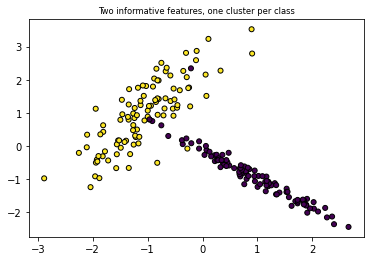

In [12]:
# First simulated data set
plt.title("Two informative features, one cluster per class", fontsize='small')
X1, Y1 = make_classification(n_samples=200, n_features=2, n_redundant=0, n_informative=2,
n_clusters_per_class=1)
plt.scatter(X1[:, 0], X1[:, 1], marker='o', c=Y1,s=25, edgecolor='k')

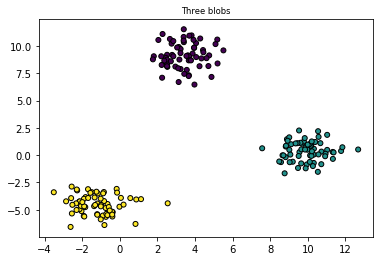

In [13]:
# Second simulated data set
plt.title("Three blobs", fontsize='small')
X2, Y2 = make_blobs(n_samples=200, n_features=2, centers=3)
plt.scatter(X2[:, 0], X2[:, 1], marker='o', c=Y2, s=25, edgecolor='k')

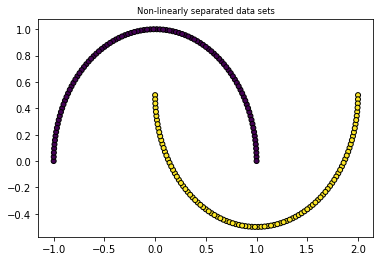

In [14]:
# Third simulated data set
plt.title("Non-linearly separated data sets", fontsize='small')
X3, Y3 = make_moons(n_samples=200, shuffle=True, noise=None, random_state=None)
plt.scatter(X3[:, 0], X3[:, 1], marker='o', c=Y3, s=25, edgecolor='k')

## 2 dimensional EM Algo

In [15]:
def get_random_psd(n):
    x = np.random.normal(0, 1, size=(n, n))
    return np.dot(x, x.transpose())


def initialize_random_params():
    params = {'phi': np.random.uniform(0, 1),
              'mu0': np.random.normal(0, 1, size=(2,)),
              'mu1': np.random.normal(0, 1, size=(2,)),
              'sigma0': get_random_psd(2),
              'sigma1': get_random_psd(2)}
    return params

def e_step(x, params):
    np.log([stats.multivariate_normal(params["mu0"], params["sigma0"]).pdf(x),
            stats.multivariate_normal(params["mu1"], params["sigma1"]).pdf(x)])
    log_p_y_x = np.log([1-params["phi"], params["phi"]])[np.newaxis, ...] + \
                np.log([stats.multivariate_normal(params["mu0"], params["sigma0"]).pdf(x),
            stats.multivariate_normal(params["mu1"], params["sigma1"]).pdf(x)]).T
    log_p_y_x_norm = logsumexp(log_p_y_x, axis=1)
    return log_p_y_x_norm, np.exp(log_p_y_x - log_p_y_x_norm[..., np.newaxis])

def m_step(x, params):
    total_count = x.shape[0]
    _, heuristics = e_step(x, params)
    heuristic0 = heuristics[:, 0]
    heuristic1 = heuristics[:, 1]
    sum_heuristic1 = np.sum(heuristic1)
    sum_heuristic0 = np.sum(heuristic0)
    phi = (sum_heuristic1/total_count)
    mu0 = (heuristic0[..., np.newaxis].T.dot(x)/sum_heuristic0).flatten()
    mu1 = (heuristic1[..., np.newaxis].T.dot(x)/sum_heuristic1).flatten()
    diff0 = x - mu0
    sigma0 = diff0.T.dot(diff0 * heuristic0[..., np.newaxis]) / sum_heuristic0
    diff1 = x - mu1
    sigma1 = diff1.T.dot(diff1 * heuristic1[..., np.newaxis]) / sum_heuristic1
    params = {'phi': phi, 'mu0': mu0, 'mu1': mu1, 'sigma0': sigma0, 'sigma1': sigma1}
    return params

def plot_cov_0(cov, mean=[0, 0], cst=6, num=200):
    cov = np.linalg.inv(np.asarray(cov))
    mean = np.asarray(mean)
    theta = np.linspace(0, 2*np.pi, num=num)
    X = np.c_[np.cos(theta), np.sin(theta)]
    X = X.T * np.sqrt(cst / np.diag(X.dot(cov.dot(X.T))))
    X = X.T + mean
    plt.plot(X[:, 0], X[:, 1], 'b')
    
def plot_cov_1(cov, mean=[0, 0], cst=6, num=200):
    cov = np.linalg.inv(np.asarray(cov))
    mean = np.asarray(mean)
    theta = np.linspace(0, 2*np.pi, num=num)
    X = np.c_[np.cos(theta), np.sin(theta)]
    X = X.T * np.sqrt(cst / np.diag(X.dot(cov.dot(X.T))))
    X = X.T + mean
    plt.plot(X[:, 0], X[:, 1], 'r')

In [16]:
para_1=initialize_random_params()

In [17]:
for i in range(1,20):
    para_1=m_step(X1, para_1)

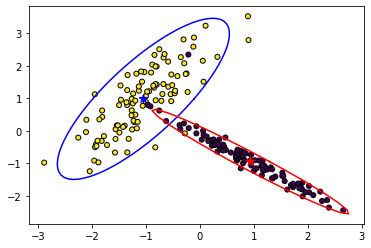

In [18]:
plt.scatter(X1[:, 0], X1[:, 1], marker='o', c=Y1,s=25, edgecolor='k')
plt.scatter((para_1['mu0'][0],para_1['mu1'][0]),(para_1['mu0'][1],para_1['mu1'][1]),s=[80,80], c=['blue','red'], marker='*')
plot_cov_0(para_1['sigma0'], para_1['mu0'])
plot_cov_1(para_1['sigma1'], para_1['mu1'])

We can see that in this case (two groups), the EM algorithm perform well, drawing two ellipses(with there covariance) in quite correct area. And the "star" points are the means of the two groups. 

# Explore the EM from the sklearn library

### On the three artificial data sets

In [19]:
from sklearn import metrics
def score_(predict_label,real_label,X_value):
    d={
        'Homogeneity': [round(metrics.homogeneity_score(predict_label,real_label),3)],
        'Completeness':   [round(metrics.completeness_score(predict_label,real_label),3)],
         'V-measure' :       [round(metrics.v_measure_score(predict_label,real_label),3)],
         'Adusted Rand-Index' :      [round(metrics.adjusted_rand_score(predict_label,real_label),3)],
      'Silhouette Coefficient':[round(metrics.silhouette_score(X_value,predict_label),3)]}
    return (d)

In [20]:
lowest_bic = np.infty
bic = []
n_components_range = range(1, 5)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
            covariance_type=cv_type)
        gmm.fit(X1)
        bic.append(gmm.bic(X1))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
            n_com = n_components
            cv_t = cv_type


y_predicted = best_gmm.predict(X1)

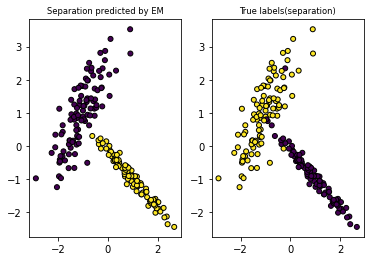

In [21]:
plt.subplot(1, 2, 1)
plt.title("Separation predicted by EM", fontsize='small')
plt.scatter(X1[:, 0], X1[:, 1], s=25, c=abs(y_predicted-1), edgecolor='k', marker='o')
plt.subplot(1, 2, 2)
plt.title("True labels(separation)", fontsize='small')
plt.scatter(X1[:, 0], X1[:, 1], marker='o', c=Y1,s=25, edgecolor='k')

plt.show()

In [22]:
pd.DataFrame(data=score_(y_predicted,Y1,X1)).style.set_caption("Score")

,Homogeneity,Completeness,V-measure,Adusted Rand-Index,Silhouette Coefficient
0,0.838000,0.838000,0.838000,0.902000,0.557000


In [23]:
print("The model selected contains",n_com,"components with "+cv_t+" covariance")

The model selected contains 2 components with full covariance


We can see that the EM algorithm perdorm well in the two dimensional separation probleme. And since it predict the distribution of the two groups, so the result given by EM method is a soft classification instead of hard classification we saw before with K-means method.

In [24]:
lowest_bic = np.infty
bic = []
n_components_range = range(1, 5)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
            covariance_type=cv_type)
        gmm.fit(X2)
        bic.append(gmm.bic(X2))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
            n_com = n_components
            cv_t = cv_type


y_predicted = best_gmm.predict(X2)

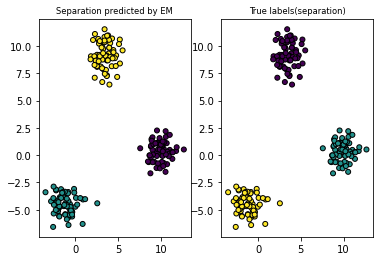

In [25]:
plt.subplot(1, 2, 1)
plt.title("Separation predicted by EM", fontsize='small')
plt.scatter(X2[:, 0], X2[:, 1], s=25, c=y_predicted, edgecolor='k', marker='o')
plt.subplot(1, 2, 2)
plt.title("True labels(separation)", fontsize='small')
plt.scatter(X2[:, 0], X2[:, 1], marker='o', c=Y2,s=25, edgecolor='k')

plt.show()

In [26]:
pd.DataFrame(data=score_(y_predicted,Y2,X2)).style.set_caption("Score")

,Homogeneity,Completeness,V-measure,Adusted Rand-Index,Silhouette Coefficient
0,1.000000,1.000000,1.000000,1.000000,0.846000


In [27]:
print("The model selected contains",n_com,"components with "+cv_t+" covariance")

The model selected contains 3 components with spherical covariance


The EM method can also perform well in the 3 groups data set.

In [28]:
lowest_bic = np.infty
bic = []
n_components_range = range(1, 5)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
            covariance_type=cv_type)
        gmm.fit(X3)
        bic.append(gmm.bic(X3))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
            n_com = n_components
            cv_t = cv_type


y_predicted = best_gmm.predict(X3)

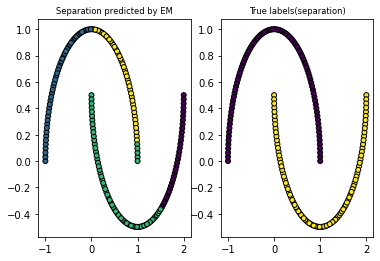

In [29]:
plt.subplot(1, 2, 1)
plt.title("Separation predicted by EM", fontsize='small')
plt.scatter(X3[:, 0], X3[:, 1], s=25, c=y_predicted, edgecolor='k', marker='o')
plt.subplot(1, 2, 2)
plt.title("True labels(separation)", fontsize='small')
plt.scatter(X3[:, 0], X3[:, 1], marker='o', c=Y3,s=25, edgecolor='k')

plt.show()

In [30]:
pd.DataFrame(data=score_(y_predicted,Y3,X3)).style.set_caption("Score")

,Homogeneity,Completeness,V-measure,Adusted Rand-Index,Silhouette Coefficient
0,0.447000,0.869000,0.590000,0.469000,0.445000


In [31]:
print("The model selected contains",n_com,"components with "+cv_t+" covariance")

The model selected contains 4 components with full covariance


We can see that the EM method predict a 4 groups separations but in fact we only have 2 groups. The EM algorithm doesn't perform well in this situation.

In [32]:
#Now we try to set the number of components ourselves and see what the ferformence of the EM Algo
gmm_2 = mixture.GaussianMixture(n_components=2,
            covariance_type=cv_type)
gmm_2.fit(X3)
y_predicted = gmm_2.predict(X3)


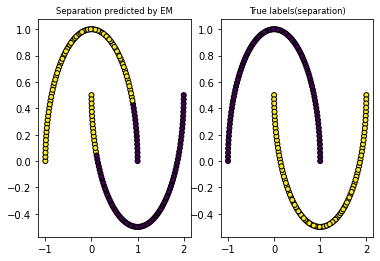

In [33]:
plt.subplot(1, 2, 1)
plt.title("Separation predicted by EM", fontsize='small')
plt.scatter(X3[:, 0], X3[:, 1], s=25, c=y_predicted, edgecolor='k', marker='o')
plt.subplot(1, 2, 2)
plt.title("True labels(separation)", fontsize='small')
plt.scatter(X3[:, 0], X3[:, 1], marker='o', c=Y3,s=25, edgecolor='k')

plt.show()

In [34]:
pd.DataFrame(data=score_(y_predicted,Y3,X3)).style.set_caption("Score")

,Homogeneity,Completeness,V-measure,Adusted Rand-Index,Silhouette Coefficient
0,0.390000,0.390000,0.390000,0.487000,0.467000


Although it is beter then the case as we don't know the number of components, the separation is still not the best we can get.

# **Data set of  Breast cancer**

### Data set preparing

In [37]:
import pandas as pd

data_Breast = pd.read_table('BreastDiagnostic.txt',sep=',',header=None)
data_Breast=data_Breast.drop([0],axis=1)
data_Breast.iloc[:,0]=data_Breast.iloc[:,0].astype("category")
display(data_Breast.iloc[:,0].value_counts(normalize = True))

B    0.627417
M    0.372583
Name: 1, dtype: float64

### Start training

In [38]:
lowest_bic = np.infty
bic = []
n_components_range = range(1, 5)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
            covariance_type=cv_type)
        gmm.fit(data_Breast.iloc[:,1:])
        bic.append(gmm.bic(data_Breast.iloc[:,1:]))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
            n_com = n_components
            cv_t = cv_type


y_predicted = best_gmm.predict(data_Breast.iloc[:,1:])
#scores for clustering methods K-means for Breast data set:
print("Homogeneity score : ",metrics.homogeneity_score(data_Breast.iloc[:,0] , y_predicted))
print("Completeness score : ",metrics.completeness_score(data_Breast.iloc[:,0] , y_predicted))
print("V-measure score : ",metrics.v_measure_score(data_Breast.iloc[:,0] , y_predicted))
print("Adjusted Rand-Index : ",metrics.adjusted_rand_score(data_Breast.iloc[:,0] , y_predicted))
print()
print("The model selected contains",n_com,"components with "+cv_t+" covariance")

Homogeneity score :  0.7030594222565626
Completeness score :  0.7092182790386102
V-measure score :  0.7061254214484894
Adjusted Rand-Index :  0.8116318038862359

The model selected contains 2 components with full covariance


# **Data set of  Mice data**

In [39]:
data_Mice = pd.read_excel("Data_Cortex_Nuclear.xls")
data_Mice=data_Mice.drop(['MouseID'],axis=1)
data_Mice.iloc[:,77:]=data_Mice.iloc[:,77:].astype("category")
data_Mice=data_Mice.drop(['ELK_N','MEK_N','Bcatenin_N','BAD_N','BCL2_N','H3AcK18_N','pCFOS_N','EGR1_N','H3MeK4_N'],axis=1)
data_Mice=data_Mice.dropna()

### Start training

In [40]:
lowest_bic = np.infty
bic = []
n_components_range = range(1, 10)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
            covariance_type=cv_type)
        gmm.fit(data_Mice.iloc[:,:67])
        bic.append(gmm.bic(data_Mice.iloc[:,:67]))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
            n_com = n_components
            cv_t = cv_type


y_predicted = best_gmm.predict(data_Mice.iloc[:,:67])
#scores for clustering methods K-means for Breast data set:
print("Homogeneity score : ",metrics.homogeneity_score(data_Mice.iloc[:,-1] , y_predicted))
print("Completeness score : ",metrics.completeness_score(data_Mice.iloc[:,-1] , y_predicted))
print("V-measure score : ",metrics.v_measure_score(data_Mice.iloc[:,-1] , y_predicted))
print("Adjusted Rand-Index : ",metrics.adjusted_rand_score(data_Mice.iloc[:,-1] , y_predicted))
print()
print("The model selected contains",n_com,"components with "+cv_t+" covariance")

Homogeneity score :  0.523062627122664
Completeness score :  0.539311012345301
V-measure score :  0.5310625649461493
Adjusted Rand-Index :  0.36789396781736183

The model selected contains 9 components with tied covariance


We observe that when the number of virables(dimensions) goes up, it is less likely that the EM algorithm can predict well. 

In conclusion:

1). When the points are linearly separable, then the EM algorithm gives out a good prediction, when there is a special stucture of the points, for example the third artificial data set who has a moon like stucture, so in this case we observe that the EM algorithm doesn't give a good prediction compare to the true labels.

2). When the dimension is too high(with too much features) the EM method can't predict correctly either, this comes from the comparison of the Breast cancer data set and the Mice data set.

3). For the data set that has a Gaussian like stucture or linear separable, the EM algorithm gives out a good performence and in addition, compare to K-means algorithm, EM algorithm gives out a soft classification that alows the interaction between different groups.